<a href="https://colab.research.google.com/github/ActionPace/DeepLearningTests/blob/master/CholletCh4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This chapter introduces convolutional neural networks, also known as convnets, a type of deep-learning model almost universally used in computer vision applications. You’ll learn to apply convnets to image-classification problems—in particular those involving small training datasets, which are the most common use case if you aren’t a large tech company.

## INTRODUCTION TO CONVNETS

We’re about to dive into the theory of what convnets are and why they have been so successful at computer vision tasks. 

But first, let’s take a practical look at a simple convnet example. It uses a convnet to classify MNIST digits, a task we performed in chapter 2 using a densely connected network (our test accuracy then was 97.8%). 

Even though the convnet will be basic, its accuracy will blow out of the water that of the densely connected model from chapter 2.

The following lines of code show you what a basic convnet looks like. It’s a stack of Conv2D and MaxPooling2D layers. You’ll see in a minute exactly what they do.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Importantly, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). 

In this case, we’ll configure the convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. 

We’ll do this by passing the argument input_shape=(28, 28, 1) to the first layer.

Let’s display the architecture of the convnet so far:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). 

The width and height dimensions tend to shrink as you go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (32 or 64).

The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely connected classifier network like those you’re already familiar with: a stack of Dense layers. 

These classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few Dense layers on top.

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We’ll do 10-way classification, using a final layer with 10 outputs and a softmax activation. Here’s what the network looks like now:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

As you can see, the (3, 3, 64) outputs are flattened into vectors of shape (576,) before going through two Dense layers.

Now, let’s train the convnet on the MNIST digits. We’ll reuse a lot of the code from the MNIST example in chapter 2.

In [0]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11493376/11490434 [==============================] - 2s 0us/step
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 12s 200us/step - loss: 0.1736 - acc: 0.9461
Epoch 2/5
60000/60000 [==============================] - 9s 146us/step - loss: 0.0482 - acc: 0.9849
Epoch 3/5
60000/60000 [==============================] - 9s 143us/step - loss: 0.0328 - acc: 0.9899
Epoch 4/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.0250 - acc: 0.9925
Epoch 5/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.0189 - acc: 0.9943


In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 1s 85us/step


0.9896

Whereas the densely connected network from chapter 2 had a test accuracy of 97.8%, the basic convnet has a test accuracy of 99.3%: we decreased the error rate by 68% (relative). Not bad!

But why does this simple convnet work so well, compared to a densely connected model? To answer this, let’s dive into what the Conv2D and MaxPooling2D layers do.

## The convolution operation

The fundamental difference between a densely connected layer and a convolution layer is this: 

Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns (see figure 5.1): in the case of images, patterns found in small 2D windows of the inputs. In the previous example, these windows were all 3 × 3.

This key characteristic gives convnets two interesting properties:

* The patterns they learn are translation invariant. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected network would have to learn the pattern anew if it appeared at a new location. This makes convnets data efficient when processing images (because the visual world is fundamentally translation invariant): they need fewer training samples to learn representations that have generalization power.
* They can learn spatial hierarchies of patterns (see figure 5.2). A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts (because the visual world is fundamentally spatially hierarchical).

Convolutions operate over 3D tensors, called feature maps, with two spatial axes (height and width) as well as a depth axis (also called the channels axis). 

For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). 

The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. 

This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. 

Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

In the MNIST example, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its input. 

Each of these 32 output channels contains a 26 × 26 grid of values, which is a response map of the filter over the input, indicating the response of that filter pattern at different locations in the input (see figure 5.3). 

That is what the term feature map means: every dimension in the depth axis is a feature (or filter), and the 2D tensor output[:, :, n] is the 2D spatial map of the response of this filter over the input.

Convolutions are defined by two key parameters:

* Size of the patches extracted from the inputs— These are typically 3 × 3 or 5 × 5. In the example, they were 3 × 3, which is a common choice.
* Depth of the output feature map— The number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.
In Keras Conv2D layers, these parameters are the first arguments passed to the layer: Conv2D(output_depth, (window_height, window_width)).

A convolution works by sliding these windows of size 3 × 3 or 5 × 5 over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of surrounding features (shape (window_height, window_width, input_depth)). 

Each such 3D patch is then transformed (via a tensor product with the same learned weight matrix, called the convolution kernel) into a 1D vector of shape (output_depth,). 

All of these vectors are then spatially reassembled into a 3D output map of shape (height, width, output_depth). 

Every spatial location in the output feature map corresponds to the same location in the input feature map (for example, the lower-right corner of the output contains information about the lower-right corner of the input). 

For instance, with 3 × 3 windows, the vector output[i, j, :] comes from the 3D patch input[i-1:i+1, j-1:j+1, :]. 

The full process is detailed in figure 5.4.

Note that the output width and height may differ from the input width and height. They may differ for two reasons:

* Border effects, which can be countered by padding the input feature map
* The use of strides, which I’ll define in a second

Let’s take a deeper look at these notions.

Understanding border effects and padding

Consider a 5 × 5 feature map (25 tiles total). 

There are only 9 tiles around which you can center a 3 × 3 window, forming a 3 × 3 grid (see figure 5.5). 

Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension, in this case. 

You can see this border effect in action in the earlier example: you start with 28 × 28 inputs, which become 26 × 26 after the first convolution layer.

If you want to get an output feature map with the same spatial dimensions as the input, you can use padding. 

Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile. 

For a 3 × 3 window, you add one column on the right, one column on the left, one row at the top, and one row at the bottom. 

For a 5 × 5 window, you add two rows (see figure 5.6).

In Conv2D layers, padding is configurable via the padding argument, which takes two values: "valid", which means no padding (only valid window locations will be used); and "same", which means “pad in such a way as to have an output with the same width and height as the input.” 

The padding argument defaults to "valid".

## Understanding convolution strides

The other factor that can influence output size is the notion of strides. 

The description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance between two successive windows is a parameter of the convolution, called its stride, which defaults to 1. 

It’s possible to have strided convolutions: convolutions with a stride higher than 1. In figure 5.7, you can see the patches extracted by a 3 × 3 convolution with stride 2 over a 5 × 5 input (without padding).

Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). 

Strided convolutions are rarely used in practice, although they can come in handy for some types of models; it’s good to be familiar with the concept.

To downsample feature maps, instead of strides, we tend to use the max-pooling operation, which you saw in action in the first convnet example. 

Let’s look at it in more depth.

## The max-pooling operation

In the convnet example, you may have noticed that the size of the feature maps is halved after every MaxPooling2D layer. 

For instance, before the first MaxPooling2D layers, the feature map is 26 × 26, but the max-pooling operation halves it to 13 × 13. 

That’s the role of max pooling: to aggressively downsample feature maps, much like strided convolutions.

Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. 

It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation. 

A big difference from convolution is that max pooling is usually done with 2 × 2 windows and stride 2, in order to downsample the feature maps by a factor of 2. On the other hand, convolution is typically done with 3 × 3 windows and no stride (stride 1).

Why downsample feature maps this way? 

Why not remove the max-pooling layers and keep fairly large feature maps all the way up? 

Let’s look at this option. The convolutional base of the model would then look like this:

In [0]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu',
                      input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [0]:
model_no_max_pool.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


What’s wrong with this setup? Two things:

* It isn’t conducive to learning a spatial hierarchy of features. The 3 × 3 windows in the third layer will only contain information coming from 7 × 7 windows in the initial input. The high-level patterns learned by the convnet will still be very small with regard to the initial input, which may not be enough to learn to classify digits (try recognizing a digit by only looking at it through windows that are 7 × 7 pixels!). We need the features from the last convolution layer to contain information about the totality of the input.
* The final feature map has 22 × 22 × 64 = 30,976 total coefficients per sample. This is huge. If you were to flatten it to stick a Dense layer of size 512 on top, that layer would have 15.8 million parameters. This is far too large for such a small model and would result in intense overfitting.

In short, the reason to use downsampling is to reduce the number of feature-map coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of the original input they cover).

Note that max pooling isn’t the only way you can achieve such downsampling. 

As you already know, you can also use strides in the prior convolution layer. 

And you can use average pooling instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the max. 

But max pooling tends to work better than these alternative solutions. In a nutshell, the reason is that features tend to encode the spatial presence of some pattern or concept over the different tiles of the feature map (hence, the term feature map), and it’s more informative to look at the maximal presence of different features than at their average presence. 

So the most reasonable subsampling strategy is to first produce dense maps of features (via unstrided convolutions) and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of the inputs (via strided convolutions) or averaging input patches, which could cause you to miss or dilute feature-presence information.

At this point, you should understand the basics of convnets—feature maps, convolution, and max pooling—and you know how to build a small convnet to solve a toy problem such as MNIST digits classification. 

Now let’s move on to more useful, practical applications.

## TRAINING A CONVNET FROM SCRATCH ON A SMALL DATASET

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. 

A “few” samples can mean anywhere from a few hundred to a few tens of thousands of images. 

As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). 

We’ll use 2,000 pictures for training—1,000 for validation, and 1,000 for testing.

In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. 

You’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. 

This will get you to a classification accuracy of 71%. At that point, the main issue will be overfitting. 

Then we’ll introduce data augmentation, a powerful technique for mitigating overfitting in computer vision. 

By using data augmentation, you’ll improve the network to reach an accuracy of 82%.

In the next section, we’ll review two more essential techniques for applying deep learning to small datasets: feature extraction with a pretrained network (which will get you to an accuracy of 90% to 96%) and fine-tuning a pretrained network (this will get you to a final accuracy of 97%). 

Together, these three strategies—training a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pretrained model—will constitute your future toolbox for tackling the problem of performing image classification with small datasets.

## The relevance of deep learning for small-data problems

You’ll sometimes hear that deep learning only works when lots of data is available. 

This is valid in part: one fundamental characteristic of deep learning is that it can find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. 

This is especially true for problems where the input samples are very high-dimensional, like images.

But what constitutes lots of samples is relative—relative to the size and depth of the network you’re trying to train, for starters. 

It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple. 

Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems. 

Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. 

You’ll see this in action in this section.

What’s more, deep-learning models are by nature highly repurposable: you can take, say, an image-classification or speech-to-text model trained on a large-scale dataset and reuse it on a significantly different problem with only minor changes. 

Specifically, in the case of computer vision, many pretrained models (usually trained on the Image-Net dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. 

That’s what you’ll do in the next section. Let’s start by getting your hands on the data.

## Downloading the data

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. 

It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream. 

You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data (you’ll need to create a Kaggle account if you don’t already have one—don’t worry, the process is painless).

The pictures are medium-resolution color JPEGs. Figure 5.8 shows some examples.

Unsurprisingly, the dogs-versus-cats Kaggle competition in 2013 was won by entrants who used convnets. 

The best entries achieved up to 95% accuracy. 

In this example, you’ll get fairly close to this accuracy (in the next section), even though you’ll train your models on less than 10% of the data that was available to the competitors.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). 

After downloading and uncompressing it, you’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

Following is the code to do this.

In [0]:
!wget https://s3.amazonaws.com/machinelearningfiles/dogsandcats-train.zip

--2019-04-15 00:09:28--  https://s3.amazonaws.com/machinelearningfiles/dogsandcats-train.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.98.133
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.98.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘dogsandcats-train.zip’

dogsandcats-train.z 100%[===================>] 543.16M  9.29MB/s    in 41s     

2019-04-15 00:10:10 (13.2 MB/s) - ‘dogsandcats-train.zip’ saved [569546721/569546721]



In [0]:
!unzip dogsandcats-train.zip

In [0]:
!ls

dogsandcats-train.zip  sample_data  train


In [0]:
!rm dogsandcats-train.zip

In [0]:
import os, shutil

original_dataset_dir = './train'    

base_dir = './cats_and_dogs_small'                 
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')                                
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')                      
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')                                  
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')                           
os.mkdir(train_cats_dir)                                                   

train_dogs_dir = os.path.join(train_dir, 'dogs')                           
os.mkdir(train_dogs_dir)                                                   

validation_cats_dir = os.path.join(validation_dir, 'cats')                 
os.mkdir(validation_cats_dir)                                              

validation_dogs_dir = os.path.join(validation_dir, 'dogs')                 
os.mkdir(validation_dogs_dir)                                              

test_cats_dir = os.path.join(test_dir, 'cats')                             
os.mkdir(test_cats_dir)                                                    

test_dogs_dir = os.path.join(test_dir, 'dogs')                             
os.mkdir(test_dogs_dir)                                                    

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]                     
for fname in fnames:                                                       
    src = os.path.join(original_dataset_dir, fname)                       
    dst = os.path.join(train_cats_dir, fname)                              
    shutil.copyfile(src, dst)                                              

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]               
for fname in fnames:                                                       
    src = os.path.join(original_dataset_dir, fname)                        
    dst = os.path.join(validation_cats_dir, fname)                         
    shutil.copyfile(src, dst)                                              

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]               
for fname in fnames:                                                       
    src = os.path.join(original_dataset_dir, fname)                        
    dst = os.path.join(test_cats_dir, fname)                               
    shutil.copyfile(src, dst)                                              

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]                     
for fname in fnames:                                                       
    src = os.path.join(original_dataset_dir, fname)                        
    dst = os.path.join(train_dogs_dir, fname)                              
    shutil.copyfile(src, dst)                                              
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]               
for fname in fnames:                                                       
    src = os.path.join(original_dataset_dir, fname)                        
    dst = os.path.join(validation_dogs_dir, fname)                         
    shutil.copyfile(src, dst)                                              

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]               
for fname in fnames:                                                       
    src = os.path.join(original_dataset_dir, fname)                        
    dst = os.path.join(test_dogs_dir, fname)                               
    shutil.copyfile(src, dst) 

In [0]:
!ls


cats_and_dogs_small  sample_data  train


In [0]:
!ls cats_and_dogs_small 

test  train  validation


In [0]:
!ls ./cats_and_dogs_small/test

cats  dogs


In [0]:
!ls ./cats_and_dogs_small/train 

cats  dogs


In [0]:
!ls ./cats_and_dogs_small/train/dogs | wc -l

1000


In [0]:
!ls ./cats_and_dogs_small/train/cats | wc -l

1000


In [0]:
!ls ./cats_and_dogs_small/test/dogs | wc -l

500


In [0]:
!ls ./cats_and_dogs_small/test/cats | wc -l

500


As a sanity check, let’s count how many pictures are in each training split (train/validation/test):

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))


total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


So you do indeed have 2,000 training images, 1,000 validation images, and 1,000 test images. 

Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

## Building your network

You built a small convnet for MNIST in the previous example, so you should be familiar with such convnets. 

You’ll reuse the same general structure: the convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

But because you’re dealing with bigger images and a more complex problem, you’ll make your network larger, accordingly: it will have one more Conv2D + MaxPooling2D stage. 

This serves both to augment the capacity of the network and to further reduce the size of the feature maps so they aren’t overly large when you reach the Flatten layer. 

Here, because you start from inputs of size 150 × 150 (a somewhat arbitrary choice), you end up with feature maps of size 7 × 7 just before the Flatten layer.

## Note

The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from 148 × 148 to 7 × 7). 

This is a pattern you’ll see in almost all convnets.

Because you’re attacking a binary-classification problem, you’ll end the network with a single unit (a Dense layer of size 1) and a sigmoid activation. 

This unit will encode the probability that the network is looking at one class or the other.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let’s look at how the dimensions of the feature maps change with every successive layer:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)       147584    
__________

For the compilation step, you’ll go with the RMSprop optimizer, as usual. 

Because you ended the network with a single sigmoid unit, you’ll use binary crossentropy as the loss (as a reminder, check out table 4.1 for a cheatsheet on what loss function to use in various situations).

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floating-point tensors before being fed into the network. 

Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. 

Keras has a module with image-processing helper tools, located at keras.preprocessing.image. 

In particular, it contains the class ImageDataGenerator, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors. This is what you’ll use here.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)             
test_datagen = ImageDataGenerator(rescale=1./255)              

train_generator = train_datagen.flow_from_directory(
        train_dir,                                             
        target_size=(150, 150),                                 
        batch_size=20,
        class_mode='binary')                                   

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Understanding Python generators

A Python generator is an object that acts as an iterator: it’s an object you can use with the for ... in operator. 

Generators are built using the yield operator.

Here is an example of a generator that yields integers:

In [0]:
def generator():
    i = 0
    while True:
        i += 1
        yield i

for item in generator():
    print(item)
    if item > 4:
        break

1
2
3
4
5


Let’s look at the output of one of these generators: it yields batches of 150 × 150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 

There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. 

For this reason, you need to break the iteration loop at some point:

In [0]:
for data_batch, labels_batch in train_generator:
     print('data batch shape:', data_batch.shape)
     print('labels batch shape:', labels_batch.shape)
     break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let’s fit the model to the data using the generator. You do so using the fit_generator method, the equivalent of fit for data generators like this one. 

It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely, like this one does. 

Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. 

This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps—the fitting process will go to the next epoch. 

In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

When using fit_generator, you can pass a validation_data argument, much as with the fit method. 

It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. 

If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 11s 113ms/step - loss: 0.6907 - acc: 0.5325 - val_loss: 0.6709 - val_acc: 0.5980
Epoch 2/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6684 - acc: 0.6065 - val_loss: 0.6602 - val_acc: 0.6110
Epoch 3/30
100/100 [==============================] - 11s 106ms/step - loss: 0.6349 - acc: 0.6485 - val_loss: 0.6359 - val_acc: 0.6490
Epoch 4/30
100/100 [==============================] - 10s 105ms/step - loss: 0.5897 - acc: 0.6940 - val_loss: 0.6038 - val_acc: 0.6630
Epoch 5/30
100/100 [==============================] - 10s 104ms/step - loss: 0.5557 - acc: 0.7145 - val_loss: 0.6403 - val_acc: 0.6360
Epoch 6/30
100/100 [==============================] - 10s 104ms/step - loss: 0.5169 - acc: 0.7370 - val_loss: 0.5985 - val_acc: 0.6800
Epoch 7/30
100/100 [==============================] - 10s 104ms/step - loss: 0.4863 - acc: 0.7620 - val_loss: 0.5704 - val_acc: 0.7040
Epoch 8/30
100/100 [==============================] - 1

It’s good practice to always save your models after training.

In [0]:
model.save('cats_and_dogs_small_1.h5')

Let’s plot the loss and accuracy of the model over the training and validation data during training (see figures 5.9 and 5.10).

<Figure size 432x288 with 0 Axes>

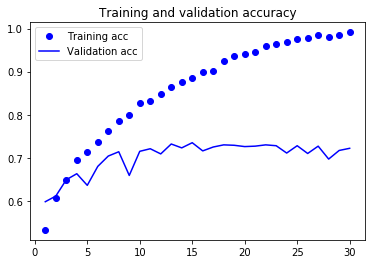

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

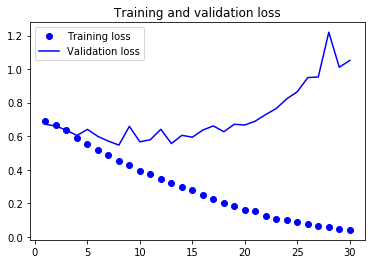

In [0]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. 

The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%. 

The validation loss reaches its minimum after only five epochs and then stalls, whereas the training loss keeps decreasing linearly until it reaches nearly 0.

Because you have relatively few training samples (2,000), overfitting will be your number-one concern. 

You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). 

We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: data augmentation.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. 

Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. 

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. 

The goal is that at training time, your model will never see the exact same picture twice. 

This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance. 

Let’s get started with an example.

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). 

Let’s quickly go over this code:

* rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* shear_range is for randomly applying shearing transformations.
* zoom_range is for randomly zooming inside pictures.
* horizontal_flip is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example, real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let’s look at the augmented images (see figure 5.11).

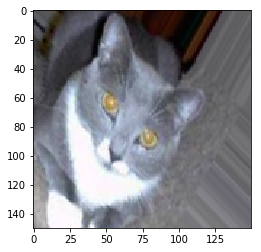

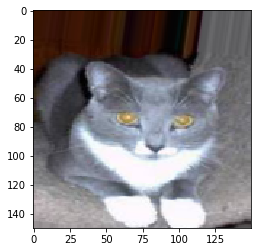

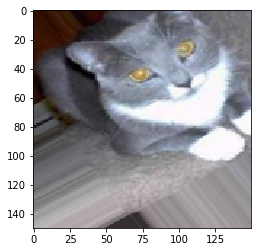

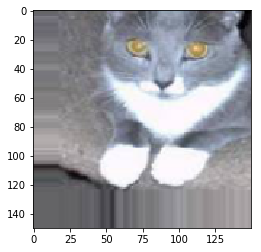

In [0]:
from keras.preprocessing import image                           

fnames = [os.path.join(train_cats_dir, fname) for
     fname in os.listdir(train_cats_dir)]

img_path = fnames[3]                                            

img = image.load_img(img_path, target_size=(150, 150))          

x = image.img_to_array(img)                                     
x = x.reshape((1,) + x.shape)                                   

i = 0                                                           
for batch in datagen.flow(x, batch_size=1):                     
    plt.figure(i)                                               
    imgplot = plt.imshow(image.array_to_img(batch[0]))          
    i += 1                                                      
    if i % 4 == 0:                                              
        break                                                   

plt.show()

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. 

But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. 

As such, this may not be enough to completely get rid of overfitting. 

To further fight overfitting, you’ll also add a Dropout layer to your model, right before the densely connected classifier.

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Let’s train the network using data augmentation and dropout.

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)               

train_generator = train_datagen.flow_from_directory(
        train_dir,                                              
        target_size=(150, 150),                                 
        batch_size=32,
        class_mode='binary')                                    

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 34s 343ms/step - loss: 0.6929 - acc: 0.5113 - val_loss: 0.7468 - val_acc: 0.5019
Epoch 2/100
100/100 [==============================] - 31s 307ms/step - loss: 0.6820 - acc: 0.5609 - val_loss: 0.6579 - val_acc: 0.6256
Epoch 3/100
100/100 [==============================] - 30s 302ms/step - loss: 0.6725 - acc: 0.5834 - val_loss: 0.6729 - val_acc: 0.5635
Epoch 4/100
100/100 [==============================] - 31s 306ms/step - loss: 0.6518 - acc: 0.6206 - val_loss: 0.6428 - val_acc: 0.6256
Epoch 5/100
100/100 [==============================] - 30s 305ms/step - loss: 0.6404 - acc: 0.6313 - val_loss: 0.6149 - val_acc: 0.6675
Epoch 6/100
100/100 [==============================] - 30s 303ms/step - loss: 0.6388 - acc: 0.6325 - val_loss: 0.5847 - val_acc: 0.6997
Epoch 7/100
100/100 [==============================] - 31s 307ms/step - loss: 0.6251 - acc: 0.6600 -

Let’s save the model—you’ll use it in section 5.4.

In [0]:
model.save('cats_and_dogs_small_2.h5')

And let’s plot the results again: see figures 5.12 and 5.13. 

Thanks to data augmentation and dropout, you’re no longer overfitting: the training curves are closely tracking the validation curves. 

You now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

<Figure size 432x288 with 0 Axes>

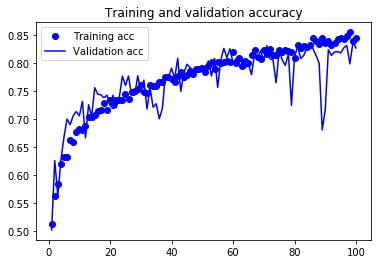

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

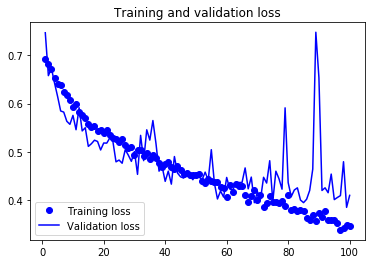

In [0]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per         convolution layer, or the number of layers in the network), you may be able to get an even better accuracy, likely up to 86%         or 87%. 

But it would prove difficult to go any higher just by training your own convnet from scratch, because you have so         little data to work with. 

As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model,         which is the focus of the next two sections.

## USING A PRETRAINED CONVNET

A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. 

A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. 

If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer-vision problems, even though these new problems may involve completely different classes than those of the original task. 

For instance, you might train a network on Image-Net (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images. 

Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective for small-data problems.

In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). 

ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to perform well on the dogs-versus-cats classification problem.

You’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet.[1] 

Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models, I chose it because its architecture is similar to what you’re already familiar with and is easy to understand without introducing any new concepts. 

This may be your first encounter with one of these cutesy model names—VGG, ResNet, Inception, Inception-ResNet, Xception, and so on; you’ll get used to them, because they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to use a pretrained network: feature extraction and fine-tuning. We’ll cover both of them. Let’s start with feature extraction.

1 Karen Simonyan and Andrew Zisserman, “Very Deep Convolutional Networks for Large-Scale Image Recognition,” arXiv (2014), https://arxiv.org/abs/1409.1556.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 

These features are then run through a new classifier, which is trained from scratch.

As you saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. 

The first part is called the convolutional base of the model. 

In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output (see figure 5.14).

Why only reuse the convolutional base? 

Could you reuse the densely connected classifier as well? 

In general, doing so should be avoided. 

The reason is that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer-vision problem at hand. 

But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained—they will only contain information about the presence probability of this or that class in the entire picture. 

Additionally, representations found in densely connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. 

For problems where object location matters, densely connected features are largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. 

Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). 

So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In this case, because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. 

But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. 

Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

The VGG16 model, among others, comes prepackaged with Keras. You can import it from the keras.applications module. Here’s the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of keras.applications:

* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let’s instantiate the VGG16 model.

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 6s 0us/step


You pass three arguments to the constructor:

* weights specifies the weight checkpoint from which to initialize the model.
* include_top refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.
* input_shape is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

Here’s the detail of the architecture of the VGG16 convolutional base. It’s similar to the simple convnets you’re already familiar with:

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape (4, 4, 512). That’s the feature on top of which you’ll stick a densely connected classifier.

At this point, there are two ways you could proceed:

* Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier similar to those you saw in part 1 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.
* Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

We’ll cover both techniques. 

Let’s walk through the code required to set up the first one: recording the output of conv_base on your data and using these outputs as inputs to a new model.

## Fast feature extraction without data augmentation

You’ll start by running instances of the previously introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. 

You’ll extract features from these images by calling the predict method of the conv_base model.

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break                                                           
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). 

You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded.

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 627us/step - loss: 0.6035 - acc: 0.6660 - val_loss: 0.4272 - val_acc: 0.8340
Epoch 2/30
2000/2000 [==============================] - 1s 388us/step - loss: 0.4280 - acc: 0.8110 - val_loss: 0.3555 - val_acc: 0.8520
Epoch 3/30
2000/2000 [==============================] - 1s 417us/step - loss: 0.3600 - acc: 0.8485 - val_loss: 0.3196 - val_acc: 0.8830
Epoch 4/30
2000/2000 [==============================] - 1s 439us/step - loss: 0.3153 - acc: 0.8665 - val_loss: 0.2964 - val_acc: 0.8790
Epoch 5/30
2000/2000 [==============================] - 1s 381us/step - loss: 0.2896 - acc: 0.8855 - val_loss: 0.2817 - val_acc: 0.8820
Epoch 6/30
2000/2000 [==============================] - 1s 390us/step - loss: 0.2615 - acc: 0.8985 - val_loss: 0.2700 - val_acc: 0.8970
Epoch 7/30
2000/2000 [==============================] - 1s 395us/step - loss: 0.2449 - acc: 0.9010 - val_loss: 0.2776 - val_acc: 0.8770


Training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU.

Let’s look at the loss and accuracy curves during training (see figures 5.15 and 5.16).

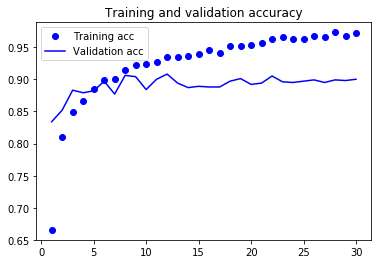

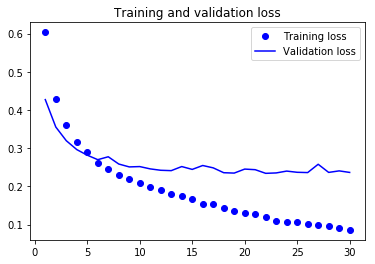

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

You reach a validation accuracy of about 90%—much better than you achieved in the previous section with the small model trained from scratch. 

But the plots also indicate that you’re overfitting almost from the start—despite using dropout with a fairly large rate. 

That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

## Feature extraction with data augmentation

Now, let’s review the second technique I mentioned for doing feature extraction, which is much slower and more expensive, but which allows you to use data augmentation during training: extending the conv_base model and running it end to end on the inputs.

## Note

This technique is so expensive that you should only attempt it if you have access to a GPU—it’s absolutely intractable on CPU. 

If you can’t run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like conv_base) to a Sequential model just like you would add a layer.

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what the model looks like now:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. 

The classifier you’re adding on top has 2 million parameters.

Before you compile and train the model, it’s very important to freeze the convolutional base. 

Freezing a layer or set of layers means preventing their weights from being updated during training. 

If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. 

Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a network by setting its trainable attribute to False:

In [0]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that you added will be trained. 

That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector). 

Note that in order for these changes to take effect, you must first compile the model. 

If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

Now you can start training your model, with the same data-augmentation configuration that you used in the previous example.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)                

train_generator = train_datagen.flow_from_directory(
        train_dir,                                               
        target_size=(150, 150),                                  
        batch_size=20,
        class_mode='binary')                                     

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 28s 284ms/step - loss: 0.5740 - acc: 0.7155 - val_loss: 0.4487 - val_acc: 0.8260
Epoch 2/30
100/100 [==============================] - 26s 258ms/step - loss: 0.4708 - acc: 0.7920 - val_loss: 0.3770 - val_acc: 0.8520
Epoch 3/30
100/100 [==============================] - 26s 259ms/step - loss: 0.4190 - acc: 0.8215 - val_loss: 0.3333 - val_acc: 0.8700
Epoch 4/30
100/100 [==============================] - 26s 261ms/step - loss: 0.3962 - acc: 0.8270 - val_loss: 0.3114 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 26s 262ms/step - loss: 0.3779 - acc: 0.8335 - val_loss: 0.2961 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 26s 263ms/step - loss: 0.3693 - acc: 0.8370 - val_loss: 0.2848 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 26s 258ms/step - loss: 0.3523 - acc: 0.8485 - val_lo

Let’s plot the results again (see figures 5.17 and 5.18). As you can see, you reach a validation accuracy of about 96%. 

This is much better than you achieved with the small convnet         trained from scratch.

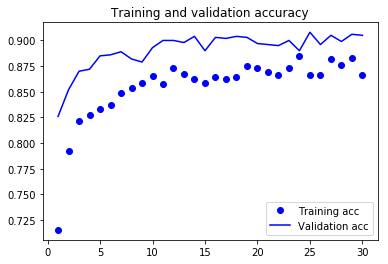

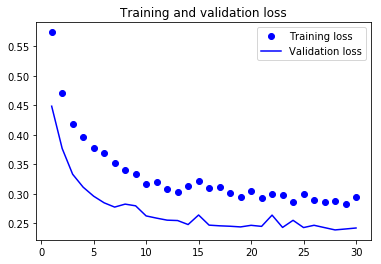

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning (see figure 5.19). 

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. 

This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

I stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. 

For the same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. 

If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. 

Thus the steps for fine-tuning a network are as follow:

1. Add your custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part you added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part you added.

You already completed the first three steps when doing feature extraction. 

Let’s proceed with step 4: you’ll unfreeze your conv_base and then freeze individual layers inside it.

As a reminder, this is what your convolutional base looks like:

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

You’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? 

You could. But you need to consider the following:

* Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
* The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset.

Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base. 

Let’s set this up, starting from where you left off in the previous example.

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now you can begin fine-tuning the network. 

You’ll do this with the RMSProp optimizer, using a very low learning rate. 

The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers you’re fine-tuning. 

Updates that are too large may harm these representations.

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 29s 294ms/step - loss: 0.2948 - acc: 0.8670 - val_loss: 0.2874 - val_acc: 0.8830
Epoch 2/100
100/100 [==============================] - 27s 270ms/step - loss: 0.2421 - acc: 0.8925 - val_loss: 0.2540 - val_acc: 0.9060
Epoch 3/100
100/100 [==============================] - 27s 272ms/step - loss: 0.2561 - acc: 0.8870 - val_loss: 0.2006 - val_acc: 0.9200
Epoch 4/100
100/100 [==============================] - 27s 269ms/step - loss: 0.2296 - acc: 0.9065 - val_loss: 0.2613 - val_acc: 0.9030
Epoch 5/100
100/100 [==============================] - 27s 268ms/step - loss: 0.1962 - acc: 0.9190 - val_loss: 0.1752 - val_acc: 0.9290
Epoch 6/100
100/100 [==============================] - 27s 269ms/step - loss: 0.1947 - acc: 0.9220 - val_loss: 0.1932 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 27s 273ms/step - loss: 0.1836 - acc: 0.9220 - val_loss: 0.1975 - val_acc: 0.9250
Epoch 8/100
100/100 [===========================

In [0]:
!ls

cats_and_dogs_small	  cats_and_dogs_small_2.h5  train
cats_and_dogs_small_1.h5  sample_data


In [0]:
model.save('cats_and_dogs_small_3.h5')

In [0]:
!ls

cats_and_dogs_small	  cats_and_dogs_small_2.h5  sample_data
cats_and_dogs_small_1.h5  cats_and_dogs_small_3.h5  train


Let’s plot the results using the same plotting code as before (see figures 5.20 and 5.21).

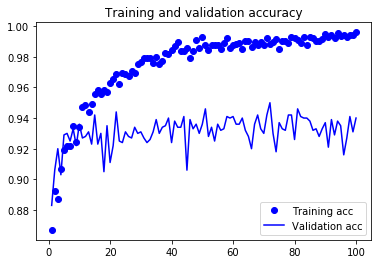

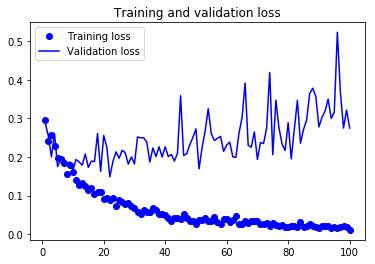

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look noisy. 

To make them more readable, you can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here’s a trivial utility function to do this (see figures 5.22 and 5.23).

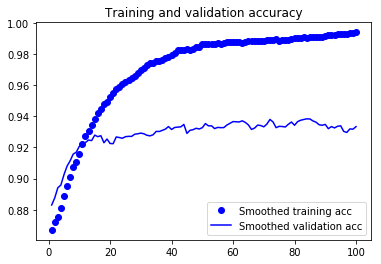

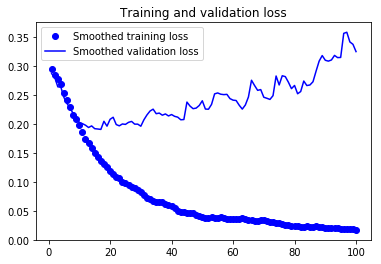

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation accuracy curve look much cleaner. You’re seeing a nice 1% absolute improvement in accuracy, from about 96% to above 97%.

Note that the loss curve doesn’t show any real improvement (in fact, it’s deteriorating). 

You may wonder, how could accuracy stay stable or improve if the loss isn’t decreasing? 

The answer is simple: what you display is an average of pointwise loss values; but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability predicted by the model. 

The model may still be improving even if this isn’t reflected in the average loss.

You can now finally evaluate this model on the test data:

In [0]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9299999940395355


Here you get a test accuracy of 97%. 

In the original Kaggle competition around this dataset, this would have been one of the top results. 

But using modern deep-learning techniques, you managed to reach this result using only a small fraction of the training data available (about 10%). 

There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Wrapping up

Here’s what you should take away from the exercises in the past two sections:

* Convnets are the best type of machine-learning models for computer-vision tasks. It’s possible to train one from scratch even on a very small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when you’re working with image data.
* It’s easy to reuse an existing convnet on a new dataset via feature extraction. This is a valuable technique for working with small image datasets.
* As a complement to feature extraction, you can use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image-classification problems—in particular with small datasets.

## VISUALIZING WHAT CONVNETS LEARN

It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. 

Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. 

The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. 

Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. 

We won’t survey all of them, but we’ll cover three of the most accessible and useful ones:

* Visualizing intermediate convnet outputs (intermediate activations)— Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters— Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
* Visualizing heatmaps of class activation in an image— Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

For the first method—activation visualization—you’ll use the small convnet that you trained from scratch on the dogs-versus-cats classification problem in section 5.2. 

For the next two methods, you’ll use the VGG16 model introduced in section 5.3.

## Visualizing intermediate activations

Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). 

This gives a view into how an input is decomposed into the different filters learned by the network. 

You want to visualize feature maps with three dimensions: width, height, and depth (channels). 

Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image. Let’s start by loading the model that you saved in section 5.2:

In [0]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Next, you’ll get an input image—a picture of a cat, not part of the images the network was trained on.

In [0]:
img_path = './cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image                             
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                               

#Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Let’s display the picture (see figure 5.24).

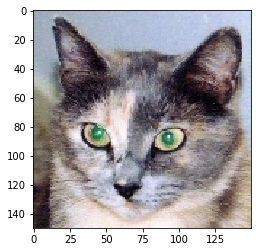

In [0]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps you want to look at, you’ll create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. 

To do this, you’ll use the Keras class Model. 

A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). 

The resulting class is a Keras model, just like the Sequential models you’re familiar with, mapping the specified inputs to the specified outputs. 

What sets the Model class apart is that it allows for models with multiple outputs, unlike Sequential. For more information about the Model class, see section 7.1.

In [0]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

When fed an image input, this model returns the values of the layer activations in the original model. 

This is the first time you’ve encountered a multi-output model in this book: until now, the models you’ve seen have had exactly one input and one output. In the general case, a model can have any number of inputs and outputs. 

This one has one input and eight outputs: one output per layer activation.

In [0]:
activations = activation_model.predict(img_tensor)  

For instance, this is the activation of the first convolution layer for the cat image input:

In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It’s a 148 × 148 feature map with 32 channels. 

Let’s try plotting the fourth channel of the activation of the first layer of the original model (see figure 5.25).

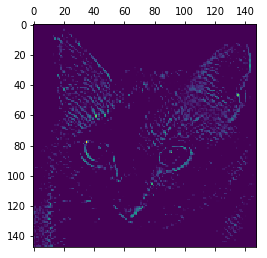

In [0]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

This channel appears to encode a diagonal edge detector. 

Let’s try the seventh channel (see figure 5.26)—but note that your own channels may vary, because the specific filters learned by convolution layers aren’t deterministic.

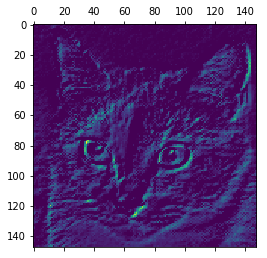

In [0]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

This one looks like a “bright green dot” detector, useful to encode cat eyes. 

At this point, let’s plot a complete visualization of all the activations in the network (see figure 5.27). 

You’ll extract and plot every channel in each of the eight activation maps, and you’ll stack the results in one big image tensor, with channels stacked side by side.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


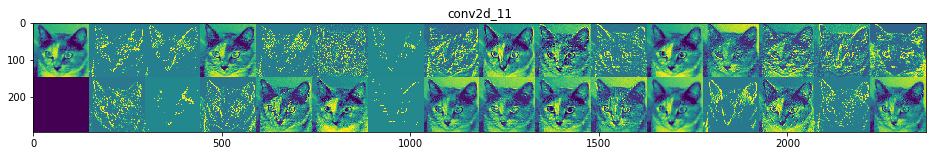

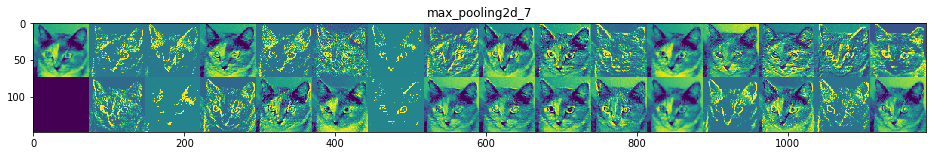

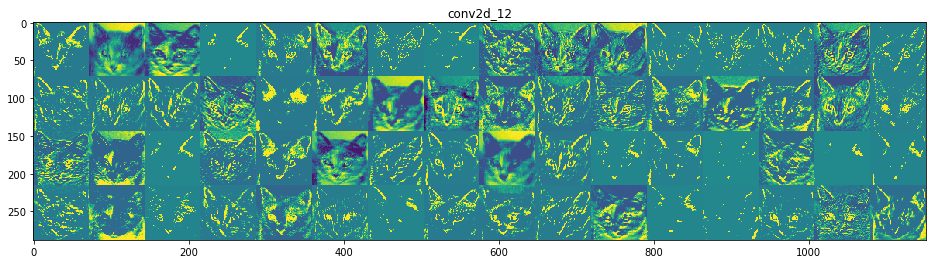

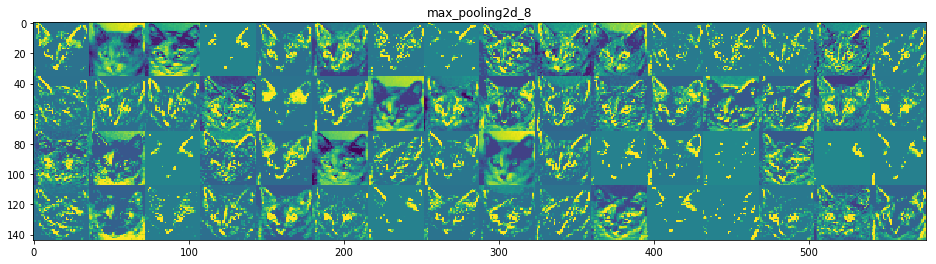

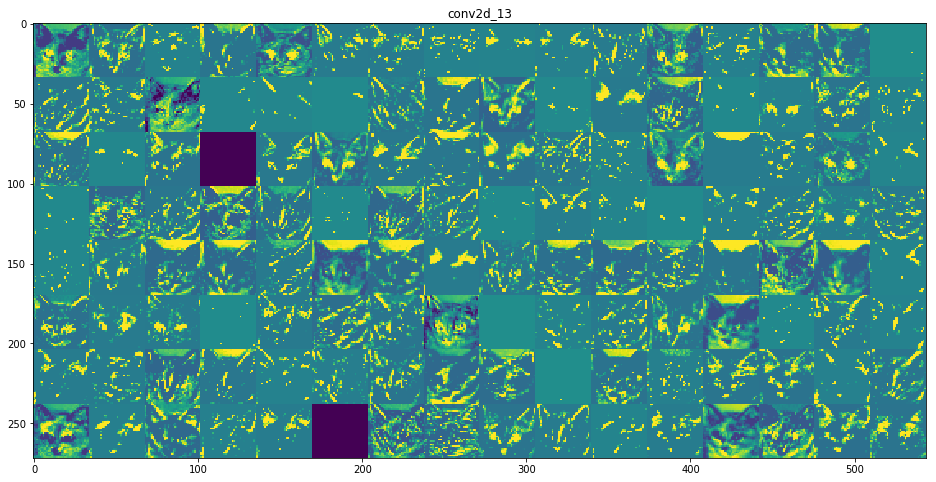

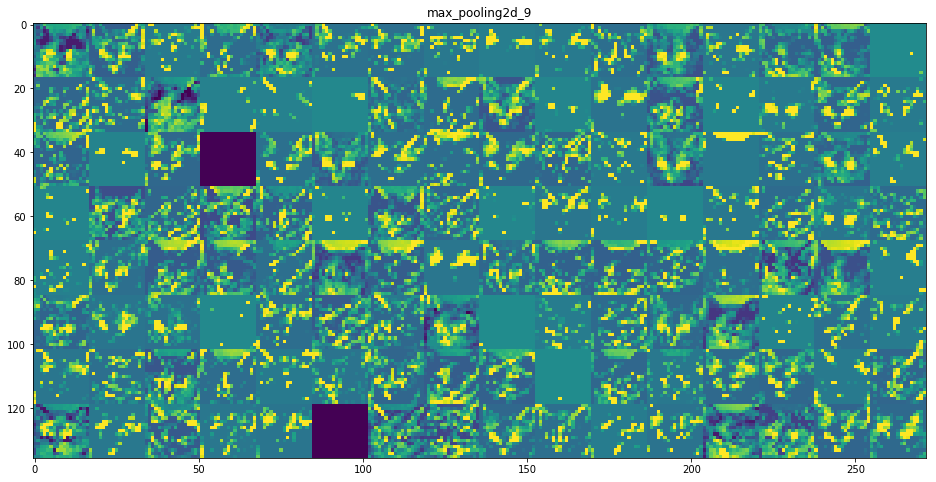

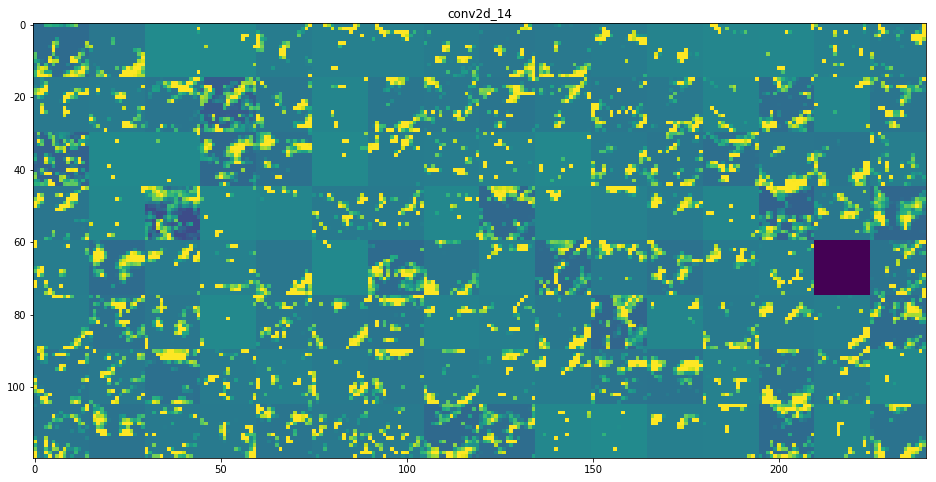

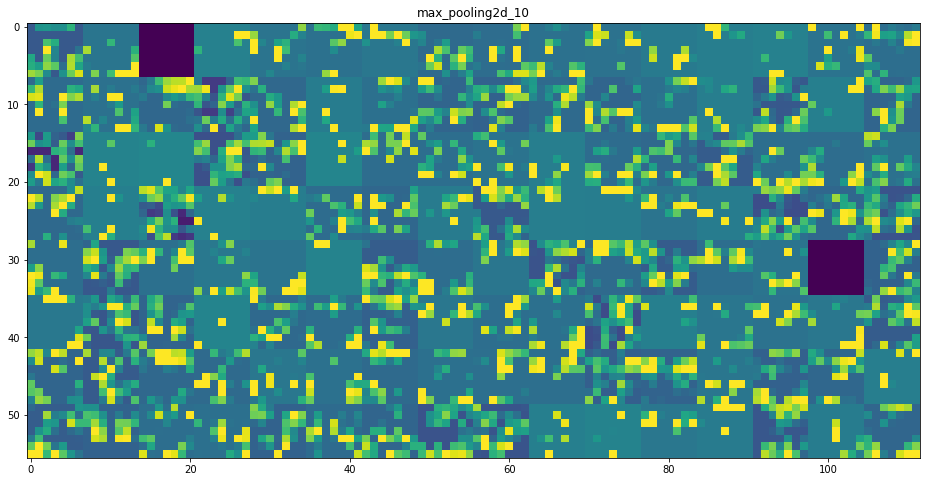

In [0]:
layer_names = []                                                          
for layer in model.layers[:8]:                                            
    layer_names.append(layer.name)                                        

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):        
    n_features = layer_activation.shape[-1]                               

    size = layer_activation.shape[1]                                      

    n_cols = n_features // images_per_row                                 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):                                             
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()                         
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                   
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

There are a few things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
* As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
* The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

We have just evidenced an important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer. 

The activations of higher layers carry less and less information about the specific input being seen, and more and more information about the target (in this case, the class of the image: cat or dog). 

A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and useful information is magnified and refined (for example, the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were present in it (bicycle, tree) but can’t remember the specific appearance of these objects. 

In fact, if you tried to draw a generic bicycle from memory, chances are you couldn’t get it even remotely right, even though you’ve seen thousands of bicycles in your lifetime (see, for example, figure 5.28). 

Try it right now: this effect is absolutely real. You brain has learned to completely abstract its visual input—to transform it into high-level visual concepts while filtering out irrelevant visual details—making it tremendously difficult to remember how things around you look.

## Visualizing convnet filters

Another easy way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. 

This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. 

The resulting input image will be one that the chosen filter is maximally responsive to.

The process is simple: you’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then you’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. 

For instance, here’s a loss for the activation of filter 0 in the layer block3_conv1 of the VGG16 network, pretrained on ImageNet.

In [0]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, you’ll need the gradient of this loss with respect to the model’s input. 

To do this, you’ll use the gradients function packaged with the backend module of Keras.

In [0]:
grads = K.gradients(loss, model.input)[0] 

A non-obvious trick to use to help the gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (the square root of the average of the square of the values in the tensor). 

This ensures that the magnitude of the updates done to the input image is always within the same range.

In [0]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  

Now you need a way to compute the value of the loss tensor and the gradient tensor, given an input image. 

You can define a Keras backend function to do this: iterate is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy tensors: the loss value and the gradient value.

In [0]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point, you can define a Python loop to do stochastic gradient descent.

In [0]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.      

step = 1.                                                           
for i in range(40):                                                  
    loss_value, grads_value = iterate([input_img_data])             

    input_img_data += grads_value * step        

The resulting image tensor is a floating-point tensor of shape (1, 150, 150, 3), with values that may not be integers within [0, 255]. 

Hence, you need to postprocess this tensor to turn it into a displayable image. You do so with the following straightforward utility function.

In [0]:
def deprocess_image(x):
    x -= x.mean()                                
    x /= (x.std() + 1e-5)                        
    x *= 0.1                                     

    x += 0.5                                     
    x = np.clip(x, 0, 1)                         

    x *= 255                                     
    x = np.clip(x, 0, 255).astype('uint8')       
    return x                                     

Now you have all the pieces. 

Let’s put them together into a Python function that takes as input a layer name and a filter index, and returns a valid image tensor representing the pattern that maximizes the activation of the specified filter.

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output                     
    loss = K.mean(layer_output[:, :, :, filter_index])                    

    grads = K.gradients(loss, model.input)[0]                             

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)                     

    iterate = K.function([model.input], [loss, grads])                    

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.     

    step = 1.                                                             
    for i in range(40):                                                   
        loss_value, grads_value = iterate([input_img_data])               
        input_img_data += grads_value * step                              

    img = input_img_data[0]
    return deprocess_image(img)

Let’s try it (see figure 5.29):

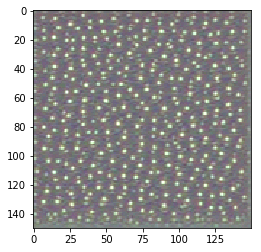

In [0]:
plt.imshow(generate_pattern('block3_conv1', 0))

It seems that filter 0 in layer block3_conv1 is responsive to a polka-dot pattern. 

Now the fun part: you can start visualizing every filter in every layer. 

For simplicity, you’ll only look at the first 64 filters in each layer, and you’ll only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1). 

You’ll arrange the outputs on an 8 × 8 grid of 64 × 64 filter patterns, with some black margins between each filter pattern (see figures 5.30–5.33).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


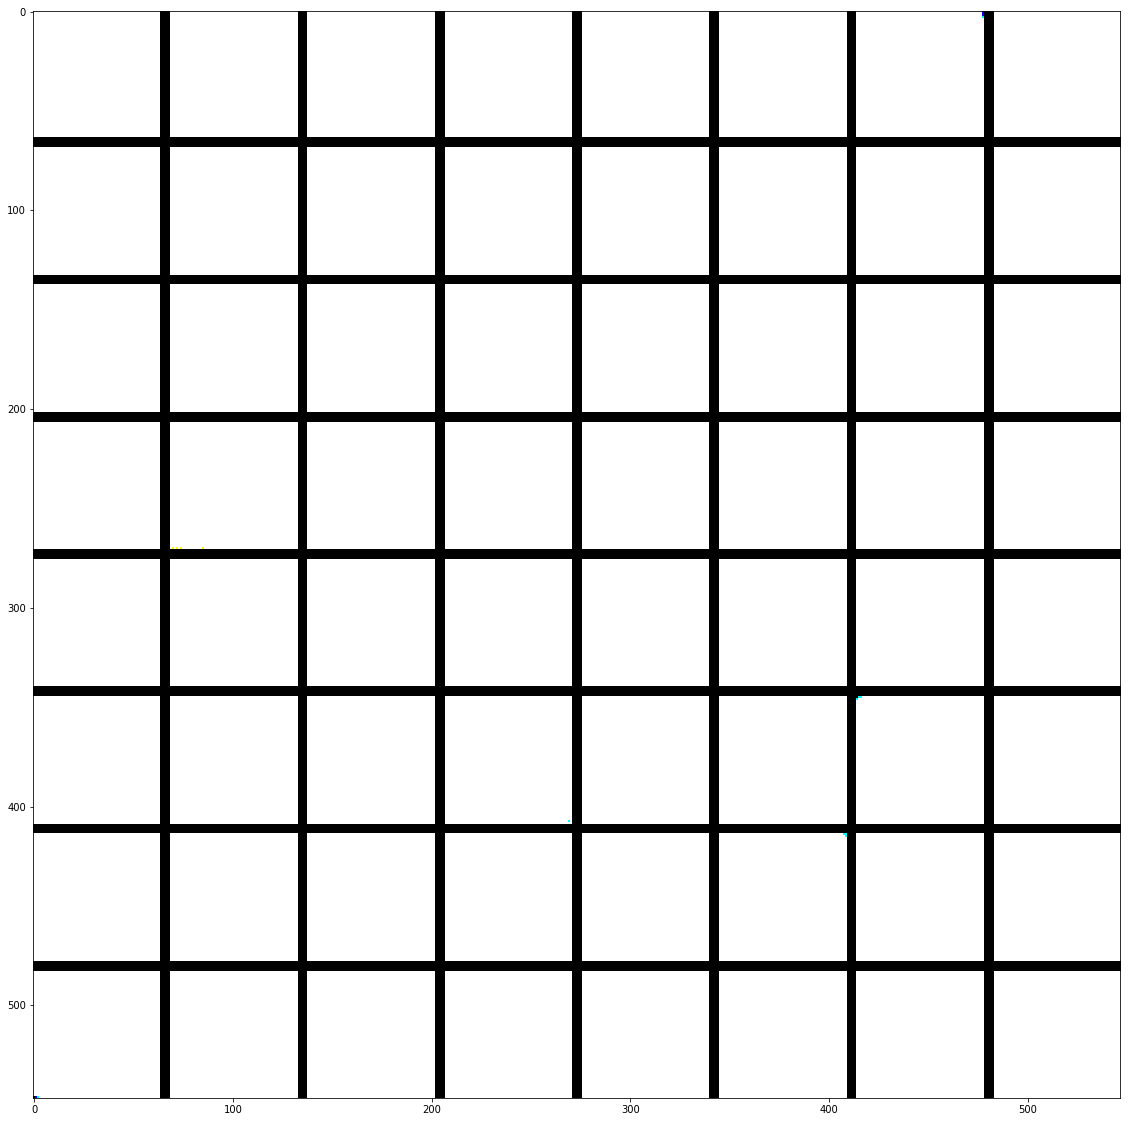

In [0]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))      

for i in range(8):                                                         
    for j in range(8):                                                     
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)  

        horizontal_start = i * size + i * margin                           
        horizontal_end = horizontal_start + size                           
        vertical_start = j * size + j * margin                             
        vertical_end = vertical_start + size                               
        results[horizontal_start: horizontal_end,                          
                vertical_start: vertical_end, :] = filter_img              

plt.figure(figsize=(20, 20))                                               
plt.imshow(results)               

These filter visualizations tell you a lot about how convnet layers see the world: each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as you go higher in the model:

* The filters from the first layer in the model (block1_conv1) encode simple directional edges and colors (or colored edges, in some cases).
* The filters from block2_conv1 encode simple textures made from combinations of edges and colors.
* The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.

## Visualizing heatmaps of class activation

I’ll introduce one more visualization technique: one that is useful for understanding which parts of a given image led a convnet to its final classification decision. 

This is helpful for debugging the decision process of a convnet, particularly in the case of a classification mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called class activation map (CAM) visualization, and it consists of producing heatmaps of class activation over input images. 

A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration. 

For instance, given an image fed into a dogs-versus-cats convnet, CAM visualization allows you to generate a heatmap for the class “cat,” indicating how cat-like different parts of the image are, and also a heatmap for the class “dog,” indicating how dog-like parts of the image are.

The specific implementation you’ll use is the one described in “Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.”[2] 

It’s very simple: it consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. 

Intuitively, one way to understand this trick is that you’re weighting a spatial map of “how intensely the input image activates different channels” by “how important each channel is with regard to the class,” resulting in a spatial map of “how intensely the input image activates the class.”

2

Ramprasaath R. Selvaraju et al., arXiv (2017), https://arxiv.org/abs/1610.02391.

We’ll demonstrate this technique using the pretrained VGG16 network again.

In [0]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')   

553467904/553467096 [==============================] - 36s 0us/step


Consider the image of two African elephants shown in figure 5.34 (under a Creative Commons license), possibly a mother and her calf, strolling on the savanna. 

Let’s convert this image into something the VGG16 model can read: the model was trained on images of size 224 × 244, preprocessed according to a few rules that are packaged in the utility function keras.applications.vgg16.preprocess_input. 

So you need to load the image, resize it to 224 × 224, convert it to a Numpy float32 tensor, and apply these preprocessing rules.

In [0]:
!wget https://www.seattleglobalist.com/wp-content/uploads/2016/07/female-elephant-341983_1280.jpg

--2019-04-15 03:22:10--  https://www.seattleglobalist.com/wp-content/uploads/2016/07/female-elephant-341983_1280.jpg
Resolving www.seattleglobalist.com (www.seattleglobalist.com)... 23.185.0.3, 2620:12a:8000::3, 2620:12a:8001::3
Connecting to www.seattleglobalist.com (www.seattleglobalist.com)|23.185.0.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190269 (186K) [image/jpeg]
Saving to: ‘female-elephant-341983_1280.jpg’

female-elephant-341 100%[===================>] 185.81K  --.-KB/s    in 0.04s   

2019-04-15 03:22:10 (4.72 MB/s) - ‘female-elephant-341983_1280.jpg’ saved [190269/190269]



In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './female-elephant-341983_1280.jpg'  

img = image.load_img(img_path, target_size=(224, 224))                   

x = image.img_to_array(img)                                              

x = np.expand_dims(x, axis=0)                                            

x = preprocess_input(x)    

You can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [0]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 9us/step
Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


The top three classes predicted for this image are as follows:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

The network has recognized the image as containing an undetermined quantity of African elephants. 

The entry in the prediction vector that was maximally activated is the one corresponding to the “African elephant” class, at index 386:

In [0]:
np.argmax(preds[0])

386

In [0]:
african_elephant_output = model.output[:, 386]                          

last_conv_layer = model.get_layer('block5_conv3')                         

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]   

pooled_grads = K.mean(grads, axis=(0, 1, 2))                              

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])           

pooled_grads_value, conv_layer_output_value = iterate([x])                

for i in range(512):                                                      
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]             

heatmap = np.mean(conv_layer_output_value, axis=-1)       

For visualization purposes, you’ll also normalize the heatmap between 0 and 1. The result is shown in figure 5.35.

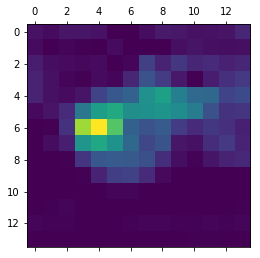

In [0]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Finally, you’ll use OpenCV to generate an image that superimposes the original image on the heatmap you just obtained (see figure 5.36).

In [0]:
import cv2

img = cv2.imread(img_path)                                                 

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))                

heatmap = np.uint8(255 * heatmap)                                          

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)                     

superimposed_img = heatmap * 0.4 + img                                     

cv2.imwrite('./elephant_cam.jpg', superimposed_img)

True

This visualization technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it’s interesting to note that the ears of the elephant calf are strongly activated: this is probably how the network can tell the difference between African and Indian elephants.

## Chapter summary

* Convnets are the best tool for attacking visual-classification problems.
* Convnets work by learning a hierarchy of modular patterns and concepts to represent the visual world.
* The representations they learn are easy to inspect—convnets are the opposite of black boxes!
* You’re now capable of training your own convnet from scratch to solve an image-classification problem.
* You understand how to use visual data augmentation to fight overfitting.
* You know how to use a pretrained convnet to do feature extraction and fine-tuning.
* You can generate visualizations of the filters learned by your convnets, as well as heatmaps of class activity.